<a href="https://colab.research.google.com/github/lmtkhanh/Week4-Neural_Network/blob/document/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Loading Libraries and Data Files**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import nltk
import librosa

In [3]:
features=pd.read_excel('/content/drive/MyDrive/IAT 481/featuresCombined.xlsx',index_col=0)
emotions=pd.read_excel('/content/drive/MyDrive/IAT 481/emotionsCombined.xlsx',index_col=0)

In [4]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.636684,0.628297,0.631292,0.651613,0.698669,0.767675,0.781398,0.741129,0.741146,0.705466,...,-1.673998,-0.503829,0.026309,0.215442,1.812259,2.770561,1.646000,2.532423,0.569808,1.190669
1,0.619704,0.639446,0.650099,0.693850,0.721269,0.756798,0.789992,0.768492,0.766670,0.698196,...,-1.135965,-0.554937,-1.294901,-0.990536,-0.618531,0.289876,-0.120279,0.519724,1.181626,2.576108
2,0.615388,0.598130,0.632746,0.687002,0.735016,0.746685,0.735427,0.738268,0.771911,0.697520,...,-3.166279,0.292470,-1.585585,-0.819369,-1.223765,0.182237,0.581931,2.988665,3.700677,4.860653
3,0.666090,0.641014,0.625757,0.668821,0.702518,0.748449,0.786031,0.716457,0.713515,0.666831,...,-1.627202,1.990687,1.660290,1.184242,1.871421,1.095554,0.522881,0.699638,0.359175,1.215944
4,0.601642,0.617534,0.665111,0.690098,0.711811,0.743393,0.746468,0.811313,0.819656,0.768950,...,-1.931422,0.705211,-1.421736,0.109918,0.826748,3.198303,3.540084,4.285282,5.466786,6.817317


In [5]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
labels_df=pd.DataFrame(emotions)



Audio samples represented: 1508
Numerical features extracted per sample: 180


['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad'] [319 238 260 262 175 254]


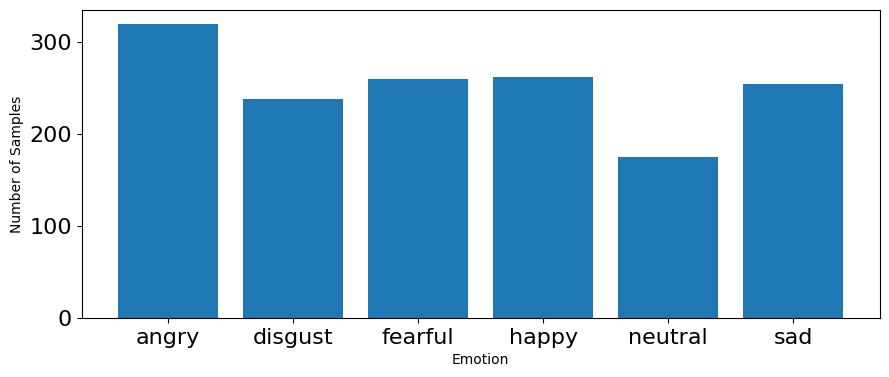

In [6]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
print(emotion_list,count)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

## **Feature Scaling**

In [7]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.276,     max = 0.888,     mean = 0.640,     deviation = 0.093

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.328,     deviation = 9.748

40 MFCC features:                 min = -863.639,    max = 121.174,    mean = -11.163,    deviation = 82.575


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

In [9]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -4.046,     max = 2.602,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.599,     deviation = 0.179

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.177


## **MLP Model for Classification**

### Training: 80/20 Split

In [10]:
from sklearn.model_selection import train_test_split
############# Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

### MLP Initialization

In [11]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(
    random_state = 69
)

#################### unscaled features #####################
X_train, X_test, y_train, y_test = train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Possible emotions predicted by model:['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
Unscaled MLP Model's accuracy on training set is 58.96%
Unscaled MLP Model's accuracy on test set is 52.32%


In [12]:
#################### minmax scaled #######################
# Rebuild the training set from the minmax scaled features
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax,
    emotions,
    test_size=0.2,
    random_state=69
)

# Fit the model again on the minmax scaled features
model.fit(X_train_minmax, y_train)

print(f'MinMax scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'MinMax sacled MLP Model\'s accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%\n')

#################### standard scaled #######################
# Rebuild the training set from the standard scaled features
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)
# Fit the model again on the scaled features
model.fit(X_train_scaled, y_train)

print(f'Standard scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Standard scaled MLP Model\'s accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MinMax scaled MLP Model's accuracy on training set is 64.01%
MinMax sacled MLP Model's accuracy on test set is 50.66%

Standard scaled MLP Model's accuracy on training set is 91.63%
Standard scaled MLP Model's accuracy on test set is 69.87%


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Choice of hyperparamters

In [14]:
# %% [code]
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend


# Now that we know standard scaling is best for our features, we'll use those for our training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later
    batch_size=256,
    # keep random state constant to accurately compare subsequent models
    random_state=69
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(180,), (300,),(100,50,)],
    'activation': ['relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    #'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant']
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models
grid = GridSearchCV(
    model,
    parameter_space,
    cv=10,
    n_jobs=-1,
    verbose=10)
# Fit the models specified by the parameter grid
with parallel_backend('multiprocessing'):
    grid.fit(X_train, y_train)


# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

[CV 1/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 2/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 10 folds for each of 48 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.521 total time=   9.6s
[CV 3/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.521 total time=  10.0s
[CV 4/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.570 total time=   8.8s
[CV 5/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.504 total time=   8.8s
[CV 6/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.537 total time=  12.2s
[CV 7/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.554 total time=  12.0s
[CV 8/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.508 total time=  13.6s
[CV 9/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.525 total time=  13.7s
[CV 10/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.525 total time=  12.0s
[CV 1/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.517 total time=  11.9s
[CV 2/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.603 total time=  16.1s
[CV 3/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.661 total time=  16.9s
[CV 4/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.686 total time=  17.3s
[CV 5/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.719 total time=  18.0s
[CV 6/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.686 total time=  14.2s
[CV 7/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.678 total time=  13.7s
[CV 8/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.650 total time=  13.7s
[CV 9/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.658 total time=  13.6s
[CV 10/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.650 total time=  16.5s
[CV 1/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.692 total time=  17.7s
[CV 2/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.521 total time=  17.4s
[CV 3/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.521 total time=  16.5s
[CV 4/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.570 total time=  15.1s
[CV 5/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.504 total time=  14.7s
[CV 6/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.537 total time=  15.7s
[CV 7/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.554 total time=  16.3s
[CV 8/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.508 total time=  16.5s
[CV 9/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.525 total time=  17.7s
[CV 10/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.525 total time=  11.3s
[CV 1/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.517 total time=   9.7s
[CV 2/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.603 total time=  10.7s
[CV 3/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.661 total time=  10.6s
[CV 4/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.686 total time=  11.2s
[CV 5/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.719 total time=  11.1s
[CV 6/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.686 total time=   8.2s
[CV 7/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.678 total time=   8.2s
[CV 8/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.650 total time=  10.2s
[CV 9/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.658 total time=  10.5s
[CV 10/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.650 total time=  10.7s
[CV 1/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.692 total time=  10.9s
[CV 2/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.562 total time=  11.8s
[CV 3/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.529 total time=  13.4s
[CV 4/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.628 total time=  13.0s
[CV 5/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.537 total time=  12.4s
[CV 6/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.512 total time=  13.2s
[CV 7/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.521 total time=  12.0s
[CV 8/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.542 total time=  15.5s
[CV 9/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.583 total time=  16.4s
[CV 10/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.608 total time=  13.2s
[CV 1/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.558 total time=  12.6s
[CV 2/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.653 total time=  14.4s
[CV 3/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.628 total time=  14.0s
[CV 4/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.661 total time=  14.2s
[CV 5/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.727 total time=  14.2s
[CV 6/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.760 total time=  14.2s
[CV 7/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.686 total time=  14.1s
[CV 8/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.667 total time=  15.0s
[CV 9/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.617 total time=  14.7s
[CV 10/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.625 total time=  14.3s
[CV 1/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.708 total time=  14.1s
[CV 2/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.562 total time=  12.8s
[CV 3/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.529 total time=  13.2s
[CV 4/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.628 total time=  14.6s
[CV 5/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.537 total time=  15.4s
[CV 6/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.512 total time=  13.8s
[CV 7/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.521 total time=  13.1s
[CV 8/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.542 total time=  13.2s
[CV 9/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.583 total time=  13.0s
[CV 10/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.608 total time=  13.3s
[CV 1/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.558 total time=  13.7s
[CV 2/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.653 total time=  13.8s
[CV 3/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.628 total time=  13.5s
[CV 4/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.661 total time=  13.6s
[CV 5/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.727 total time=  13.9s
[CV 6/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.760 total time=  13.6s
[CV 7/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.686 total time=  13.7s
[CV 8/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.667 total time=  14.0s
[CV 9/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.617 total time=  13.8s
[CV 10/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.625 total time=  14.1s
[CV 1/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.708 total time=  14.2s
[CV 2/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.620 total time=  11.6s

[CV 3/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.545 total time=  11.0s
[CV 4/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.570 total time=   6.7s
[CV 5/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.545 total time=   6.6s
[CV 6/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.545 total time=   9.2s
[CV 7/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.570 total time=   9.5s
[CV 8/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.508 total time=   7.2s
[CV 9/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.500 total time=   7.5s
[CV 10/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.550 total time=   8.1s
[CV 1/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.525 total time=   8.6s
[CV 2/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.603 total time=   8.7s
[CV 3/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.653 total time=   9.2s
[CV 4/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.678 total time=   7.9s
[CV 5/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.727 total time=   7.7s
[CV 6/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.719 total time=  10.2s
[CV 7/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.653 total time=   9.7s
[CV 8/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.650 total time=   7.3s
[CV 9/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.542 total time=   7.2s
[CV 10/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.658 total time=   9.4s
[CV 1/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.600 total time=   9.7s
[CV 2/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.620 total time=   7.2s
[CV 2/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.545 total time=   7.0s
[CV 3/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd[CV 4/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.545 total time=   8.5s
[CV 5/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.570 total time=   8.7s
[CV 6/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.570 total time=   7.8s
[CV 7/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.545 total time=   8.1s
[CV 8/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.500 total time=  10.2s
[CV 9/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.508 total time=  10.0s
[CV 10/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.525 total time=   8.7s
[CV 1/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.550 total time=   8.9s
[CV 2/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.603 total time=   7.0s
[CV 3/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.653 total time=   7.3s
[CV 4/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.678 total time=   9.5s
[CV 5/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.727 total time=   9.3s
[CV 6/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.719 total time=   8.4s
[CV 7/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.653 total time=   8.8s
[CV 8/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.650 total time=   8.3s
[CV 9/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.542 total time=   7.9s
[CV 10/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.600 total time=  10.0s
[CV 1/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.658 total time=   9.7s
[CV 2/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.521 total time=   7.4s
[CV 3/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.521 total time=   7.4s
[CV 4/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.570 total time=   9.4s
[CV 5/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.504 total time=   9.7s
[CV 6/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.537 total time=   8.7s
[CV 7/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.554 total time=   8.6s
[CV 8/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.508 total time=   8.4s
[CV 9/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.525 total time=   8.1s
[CV 10/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.525 total time=   9.5s
[CV 1/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.517 total time=   9.7s
[CV 2/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.620 total time=   8.0s
[CV 3/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.669 total time=   8.0s
[CV 4/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.702 total time=  12.4s
[CV 5/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.727 total time=  12.5s
[CV 6/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.694 total time=  10.3s
[CV 7/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.678 total time=  10.1s
[CV 8/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.650 total time=   8.2s
[CV 9/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.658 total time=   8.1s
[CV 10/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.658 total time=  10.3s
[CV 1/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.692 total time=  10.2s
[CV 2/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.521 total time=   9.2s
[CV 3/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.521 total time=   9.8s
[CV 4/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.570 total time=   7.8s
[CV 5/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.504 total time=   7.5s
[CV 6/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.537 total time=   9.8s
[CV 7/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.554 total time=   9.7s
[CV 8/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.508 total time=   7.7s
[CV 8/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.525 total time=   7.5s[CV 9/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.517 total time=   9.4s
[CV 1/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.525 total time=   9.6s
[CV 2/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.620 total time=  10.4s
[CV 3/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.669 total time=  10.4s
[CV 4/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.727 total time=   8.0s
[CV 5/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.702 total time=   8.2s
[CV 6/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.678 total time=  10.1s
[CV 7/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam
[CV 5/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.694 total time=  10.3s
[CV 8/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

[CV 7/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.650 total time=  12.4s
[CV 9/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam[CV 8/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.658 total time=  12.4s



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.658 total time=   8.1s
[CV 1/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.692 total time=   8.5s
[CV 2/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.570 total time=  13.2s
[CV 3/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.529 total time=  13.1s
[CV 4/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.628 total time=  13.3s
[CV 5/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.537 total time=  13.2s
[CV 6/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.521 total time=  12.9s
[CV 7/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.521 total time=  13.2s
[CV 8/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.542 total time=  13.0s
[CV 9/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.583 total time=  12.8s
[CV 10/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.608 total time=  12.9s
[CV 1/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.558 total time=  13.2s
[CV 2/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.628 total time=  14.0s
[CV 3/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.628 total time=  14.1s
[CV 4/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.661 total time=  14.2s
[CV 5/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.711 total time=  14.1s
[CV 6/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.752 total time=  15.8s
[CV 7/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.686 total time=  15.7s
[CV 8/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.675 total time=  14.2s
[CV 9/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.625 total time=  14.3s
[CV 10/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.617 total time=  14.3s
[CV 1/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.700 total time=  14.3s
[CV 2/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.570 total time=  12.9s
[CV 3/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.529 total time=  13.1s
[CV 4/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.628 total time=  12.7s
[CV 5/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.537 total time=  13.0s
[CV 6/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.521 total time=  11.6s
[CV 7/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.521 total time=  12.0s
[CV 8/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.542 total time=  13.0s
[CV 9/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.583 total time=  12.3s
[CV 10/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.608 total time=  13.2s
[CV 1/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.558 total time=  13.3s
[CV 2/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.628 total time=  16.3s
[CV 3/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.628 total time=  16.2s
[CV 4/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.661 total time=  14.0s
[CV 5/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.711 total time=  14.1s
[CV 6/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.752 total time=  13.9s
[CV 7/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.686 total time=  14.0s
[CV 8/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.675 total time=  14.2s
[CV 9/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.625 total time=  14.1s
[CV 10/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.617 total time=  13.9s
[CV 1/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.700 total time=  14.1s
[CV 2/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.620 total time=   8.2s
[CV 3/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.545 total time=   9.0s
[CV 4/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.570 total time=   8.0s
[CV 5/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.545 total time=   7.1s
[CV 6/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.570 total time=   9.0s
[CV 7/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.545 total time=   9.2s
[CV 8/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.500 total time=   6.8s
[CV 9/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.508 total time=   6.9s
[CV 10/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.525 total time=   9.0s[CV 1/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.550 total time=   9.8s
[CV 2/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.612 total time=  11.4s
[CV 3/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.645 total time=  10.8s
[CV 4/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.669 total time=   8.1s
[CV 5/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.711 total time=   7.3s
[CV 6/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.719 total time=   9.3s
[CV 7/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.661 total time=  10.0s
[CV 8/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.633 total time=   7.3s
[CV 9/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.567 total time=   7.2s
[CV 10/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.592 total time=   9.5s
[CV 1/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.650 total time=   9.5s
[CV 2/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.620 total time=   6.5s
[CV 3/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.545 total time=   8.4s
[CV 4/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.570 total time=   9.3s
[CV 5/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.545 total time=   7.6s
[CV 6/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.570 total time=   8.6s
[CV 7/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.545 total time=   9.4s
[CV 8/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.500 total time=   7.6s
[CV 9/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.508 total time=   6.8s
[CV 10/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.525 total time=   9.2s
[CV 1/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.550 total time=   9.3s
[CV 2/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.612 total time=   7.4s
[CV 3/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.645 total time=   7.4s
[CV 4/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.669 total time=   9.8s
[CV 5/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.711 total time=   9.9s
[CV 6/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.719 total time=   8.3s
[CV 7/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.661 total time=   9.7s
[CV 8/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.633 total time=  11.0s
[CV 9/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.567 total time=   9.3s
[CV 10/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.592 total time=   9.4s
[CV 1/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.650 total time=   9.7s
[CV 2/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.446 total time=   8.6s
[CV 3/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.438 total time=   8.1s
[CV 4/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.413 total time=  10.4s
[CV 5/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.413 total time=  10.6s
[CV 6/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.430 total time=  10.1s
[CV 7/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.496 total time=  10.4s
[CV 8/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.375 total time=   8.5s
[CV 9/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.383 total time=   8.2s
[CV 10/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.483 total time=  10.6s
[CV 1/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.483 total time=  10.6s
[CV 2/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  11.0s
[CV 3/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.587 total time=  11.2s
[CV 4/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.628 total time=   9.2s
[CV 5/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.612 total time=   9.4s
[CV 6/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.587 total time=  11.2s
[CV 7/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.579 total time=  10.9s
[CV 8/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.550 total time=  12.8s
[CV 9/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.583 total time=  13.3s
[CV 10/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.525 total time=  11.8s
[CV 1/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.575 total time=  11.1s
[CV 2/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.446 total time=   8.4s
[CV 3/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.438 total time=   9.5s
[CV 4/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.413 total time=  10.2s
[CV 5/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.413 total time=   9.1s
[CV 6/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.430 total time=  10.3s
[CV 7/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.496 total time=  10.3s
[CV 8/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.375 total time=   8.1s
[CV 9/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.383 total time=   9.3s
[CV 10/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.483 total time=  10.4s
[CV 1/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.483 total time=   9.4s
[CV 2/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.496 total time=  10.9s
[CV 3/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.587 total time=  11.0s
[CV 4/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.628 total time=   9.6s
[CV 5/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.612 total time=  11.2s
[CV 6/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.587 total time=  10.3s
[CV 7/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.579 total time=   9.0s
[CV 8/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.550 total time=  11.2s
[CV 9/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.583 total time=  11.0s
[CV 10/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.525 total time=  13.3s
[CV 1/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.575 total time=  13.3s
[CV 2/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.455 total time=  14.4s
[CV 3/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.438 total time=  14.3s
[CV 4/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.496 total time=  14.3s
[CV 5/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.438 total time=  14.0s
[CV 6/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.421 total time=  14.2s
[CV 7/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.471 total time=  14.3s
[CV 8/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.408 total time=  14.4s
[CV 9/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.400 total time=  14.5s
[CV 10/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.492 total time=  14.3s
[CV 1/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.492 total time=  14.4s
[CV 2/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.488 total time=  15.5s
[CV 3/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.620 total time=  15.4s
[CV 4/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.628 total time=  16.9s
[CV 5/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.612 total time=  17.3s
[CV 6/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.603 total time=  16.4s
[CV 7/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.595 total time=  15.4s
[CV 8/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.567 total time=  15.3s
[CV 9/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.575 total time=  15.3s
[CV 10/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.517 total time=  15.6s
[CV 1/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.600 total time=  15.2s
[CV 2/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.455 total time=  14.2s
[CV 3/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.438 total time=  14.4s
[CV 4/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.496 total time=  14.5s
[CV 5/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.438 total time=  14.4s
[CV 6/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.421 total time=  14.2s
[CV 7/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.471 total time=  14.3s
[CV 8/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.408 total time=  14.5s
[CV 9/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.400 total time=  14.4s
[CV 10/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.492 total time=  16.9s
[CV 1/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.492 total time=  17.1s
[CV 2/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.488 total time=  15.3s
[CV 3/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.620 total time=  15.3s
[CV 4/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.628 total time=  15.4s
[CV 5/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.612 total time=  15.6s
[CV 6/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.603 total time=  16.2s
[CV 7/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.595 total time=  16.1s
[CV 8/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.567 total time=  15.8s
[CV 9/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.575 total time=  15.7s
[CV 10/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.517 total time=  15.9s
[CV 1/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.600 total time=  15.6s
[CV 2/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.223 total time=   7.4s
[CV 3/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.223 total time=   7.3s
[CV 4/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.223 total time=  12.0s
[CV 5/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.215 total time=  11.9s
[CV 6/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.215 total time=   9.2s
[CV 7/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.215 total time=   9.1s
[CV 8/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.217 total time=   7.8s
[CV 9/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.217 total time=   8.2s
[CV 10/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.225 total time=   9.4s
[CV 1/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.225 total time=  10.0s
[CV 2/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.545 total time=   8.1s
[CV 3/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.603 total time=   8.2s
[CV 4/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.620 total time=  10.3s
[CV 5/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.603 total time=  10.4s
[CV 6/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.620 total time=  10.3s
[CV 7/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.587 total time=  10.2s
[CV 8/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.600 total time=   8.2s
[CV 9/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.592 total time=   8.1s
[CV 10/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.542 total time=  10.2s
[CV 1/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.583 total time=  10.1s
[CV 2/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.223 total time=   9.7s
[CV 3/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.223 total time=   9.8s
[CV 4/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.223 total time=   7.5s
[CV 5/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.215 total time=   7.5s
[CV 6/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.215 total time=  10.1s
[CV 7/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.215 total time=  10.6s
[CV 8/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.217 total time=  11.7s
[CV 9/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.217 total time=  11.8s
[CV 10/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.225 total time=   7.6s
[CV 1/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.225 total time=   7.5s
[CV 2/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.603 total time=  10.3s

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



[CV 3/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.545 total time=  10.6s
[CV 4/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.620 total time=  10.4s
[CV 5/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.603 total time=  10.6s
[CV 6/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.620 total time=   8.3s
[CV 7/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.587 total time=   8.3s
[CV 8/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.600 total time=  10.2s
[CV 9/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.592 total time=  10.4s
[CV 10/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.542 total time=  10.0s
[CV 1/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.583 total time=  10.3s
[CV 2/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.446 total time=   8.7s
[CV 3/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.438 total time=   8.3s
[CV 4/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.413 total time=  10.4s
[CV 5/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.413 total time=  10.5s
[CV 6/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.430 total time=  10.2s
[CV 7/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.496 total time=  10.5s
[CV 8/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.375 total time=   8.2s
[CV 9/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.383 total time=   8.7s
[CV 10/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.483 total time=  12.6s
[CV 1/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.483 total time=  11.8s
[CV 2/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  11.0s
[CV 3/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.595 total time=  11.0s
[CV 4/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.628 total time=   9.0s
[CV 5/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.612 total time=   8.9s
[CV 6/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.595 total time=  10.9s
[CV 7/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.579 total time=  11.1s
[CV 8/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.550 total time=  10.7s
[CV 9/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.583 total time=  11.0s
[CV 10/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.525 total time=   9.8s
[CV 1/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.575 total time=  10.4s
[CV 2/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.446 total time=   9.4s
[CV 3/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.438 total time=   8.7s
[CV 4/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.413 total time=  10.5s
[CV 5/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.413 total time=  10.1s
[CV 6/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.430 total time=   8.8s
[CV 7/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.496 total time=   9.2s
[CV 8/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.375 total time=   9.6s
[CV 9/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.383 total time=   9.5s
[CV 10/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.483 total time=  12.9s
[CV 1/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.483 total time=  12.9s
[CV 2/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.496 total time=   9.8s
[CV 3/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.595 total time=  10.4s
[CV 4/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.628 total time=  10.3s
[CV 5/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.612 total time=   9.8s
[CV 6/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.595 total time=  10.9s
[CV 7/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.579 total time=  10.9s
[CV 8/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.550 total time=  11.0s
[CV 9/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.583 total time=  11.2s
[CV 10/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.525 total time=   9.0s
[CV 1/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.575 total time=   9.1s
[CV 2/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.455 total time=  14.6s
[CV 3/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.438 total time=  14.2s

[CV 4/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.496 total time=  14.5s
[CV 5/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.438 total time=  14.2s
[CV 6/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.421 total time=  14.5s
[CV 7/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.471 total time=  14.7s
[CV 8/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.408 total time=  16.5s
[CV 9/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.392 total time=  16.5s
[CV 10/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.492 total time=  14.3s
[CV 1/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.492 total time=  14.4s
[CV 2/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.488 total time=  15.0s
[CV 3/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.612 total time=  15.3s
[CV 4/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.628 total time=  15.3s
[CV 5/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.612 total time=  16.1s
[CV 6/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.603 total time=  16.1s
[CV 7/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.595 total time=  16.2s
[CV 8/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.558 total time=  15.8s
[CV 9/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.575 total time=  16.1s
[CV 10/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.517 total time=  15.5s
[CV 1/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.600 total time=  16.9s
[CV 2/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.455 total time=  16.6s
[CV 3/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.438 total time=  15.1s
[CV 4/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.496 total time=  13.9s
[CV 5/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.438 total time=  14.5s
[CV 6/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.421 total time=  14.2s
[CV 7/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.471 total time=  14.0s
[CV 8/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.408 total time=  13.8s
[CV 9/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.392 total time=  14.1s
[CV 10/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.492 total time=  13.9s
[CV 1/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.492 total time=  14.3s
[CV 2/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.488 total time=  15.9s
[CV 3/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.612 total time=  15.1s
[CV 4/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.628 total time=  15.5s
[CV 5/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.612 total time=  16.3s
[CV 6/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.603 total time=  17.2s
[CV 7/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.595 total time=  16.3s
[CV 8/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.558 total time=  15.3s
[CV 9/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.575 total time=  15.7s
[CV 10/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.517 total time=  15.8s
[CV 1/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.600 total time=  15.6s
[CV 2/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.223 total time=   9.8s
[CV 3/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.223 total time=   9.7s
[CV 4/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.223 total time=   7.5s
[CV 5/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.215 total time=   8.9s
[CV 6/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.215 total time=   9.6s
[CV 7/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.215 total time=   8.6s
[CV 8/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.217 total time=   8.7s
[CV 9/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.217 total time=   9.9s
[CV 10/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.225 total time=   8.7s
[CV 1/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.225 total time=   7.6s
[CV 2/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.545 total time=  10.0s
[CV 3/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.603 total time=  10.4s
[CV 4/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.628 total time=  11.2s
[CV 5/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.603 total time=  12.8s
[CV 6/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.620 total time=   9.2s
[CV 7/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.579 total time=   8.2s
[CV 8/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.575 total time=  10.3s
[CV 9/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.592 total time=  10.2s
[CV 10/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.542 total time=   8.1s
[CV 1/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.575 total time=  10.0s
[CV 2/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.223 total time=   9.9s
[CV 3/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.223 total time=   7.5s
[CV 4/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.223 total time=   9.6s
[CV 5/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.215 total time=   9.6s
[CV 6/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.215 total time=   7.5s
[CV 7/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.215 total time=   8.7s
[CV 8/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.217 total time=   9.7s
[CV 9/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.217 total time=   8.4s
[CV 10/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.225 total time=   8.8s
[CV 1/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.225 total time=   9.7s
[CV 2/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.545 total time=   9.5s
[CV 3/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.603 total time=   8.0s
[CV 4/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.628 total time=  10.2s
[CV 5/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.603 total time=  10.5s
[CV 6/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.620 total time=   8.7s
[CV 7/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.579 total time=  11.3s
[CV 8/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.575 total time=  11.8s
[CV 9/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.592 total time=  10.8s
[CV 10/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.542 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.575 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters found:
 {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (180,), 'learning_rate': 'adaptive', 'solver': 'adam'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## **Training and Evaluating the MLP Model**

In [17]:
# declare again so I don't have to re-run gridsearch when I restart the jupyter kernel
# our default X_train, X_test are now standard scaled features since we know they're best
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

model = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    hidden_layer_sizes=(300,),
    learning_rate='adaptive',
    max_iter=1000, # I've found for this task, loss converges at ~1000 iterations
    random_state=69,
)

model.fit(X_train, y_train)

print(f'MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP Model's accuracy on training set is 100.00%
MLP Model's accuracy on test set is 76.16%


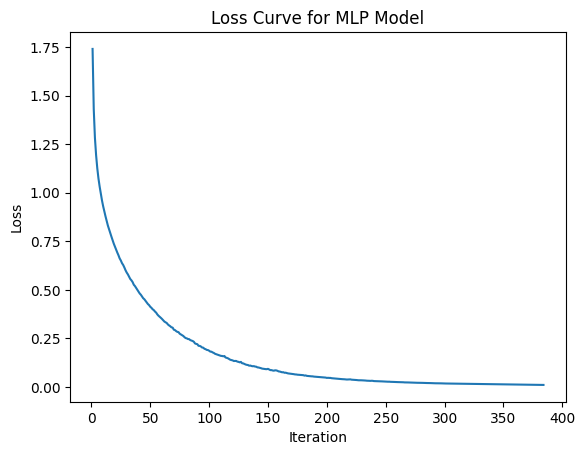

In [18]:
plt.figure()
plt.plot([num for num in range(1,model.n_iter_ +1)], model.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

### The Confusion Matrix

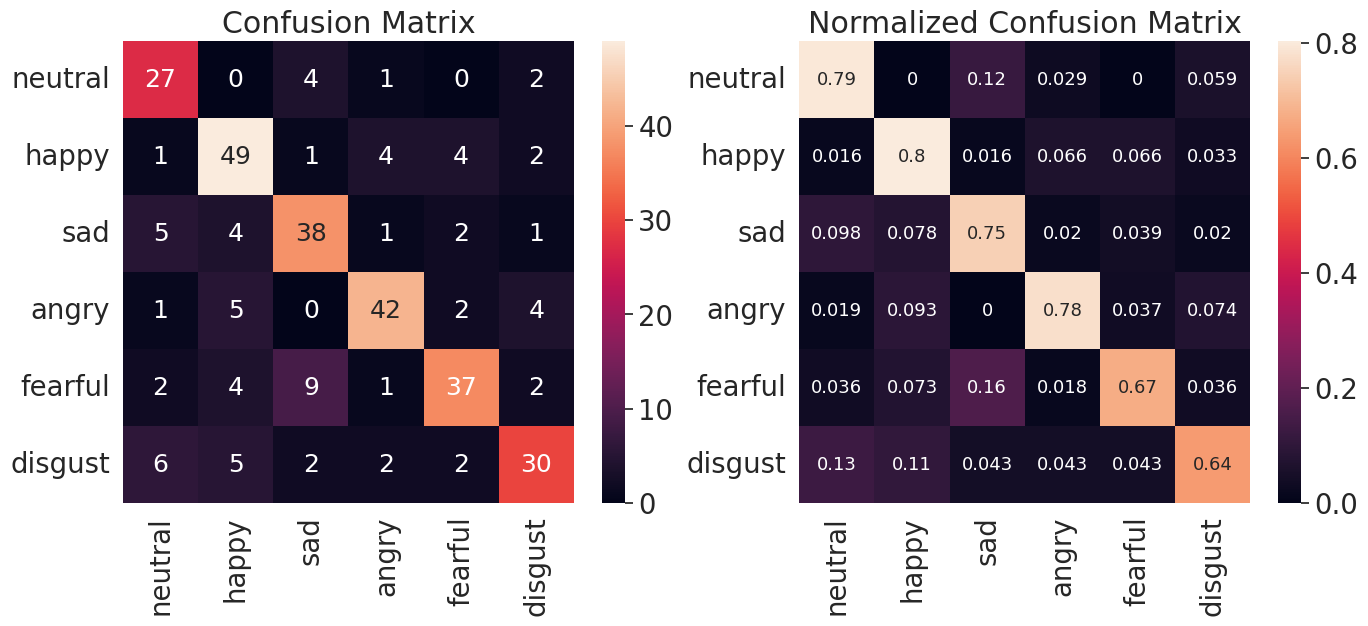

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn # I like seaborn's confusion matrix over sklearn's default

# get predictions on test set
test_emotion_predictions = model.predict(X_test)
test_emotion_groundtruth = y_test

# set labels for matrix axes from emotions
emotion_list =['neutral','happy','sad','angry','fearful','disgust']
emotion_name = [emotion for emotion in emotion_list]

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions, labels=emotion_list)
conf_matrix_norm = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions,normalize='true', labels=emotion_list)



# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

### Precision, Recall, F-Score

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  73.841%
Test Set Precision score =  73.673%
Test Set Recall score =  73.855%
Test Set F-score score =  73.5%


### K-Fold Cross-Validation

In [24]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(
    n_splits=10,
    random_state=69,
    shuffle=True
)

scores = []
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
for train_indices, test_indices in kfold.split(X_train,y_train):



    train_x=X_train.iloc[train_indices]
    train_y=y_train.iloc[train_indices]

    test_x=X_train.iloc[test_indices]
    test_y=y_train.iloc[test_indices]
    # fit model to training fold
    model.fit(train_x, train_y)
    # score the model on validation fold
    scores.append(model.score(test_x, test_y))

print('KFold CV scores for MLP:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed w

KFold CV scores for MLP:
67.77%
75.21%
66.94%
71.90%
65.29%
71.90%
65.83%
70.00%
72.50%
65.00%
Mean score of KFold CV for MLP: 69.23% ± 3.37%


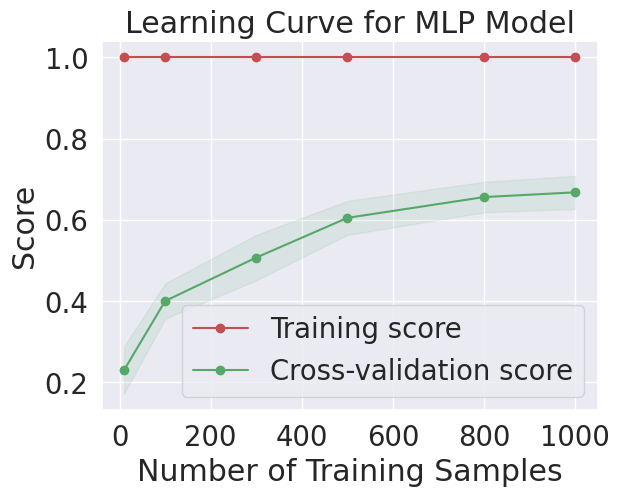

In [25]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    cv=10,
    shuffle=True,
    random_state=69,
    n_jobs=4,
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples
    train_sizes=[10,100,300,500,800, 1000] # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()